# Описание проекта

Дизайнеры захотели поменять шрифты во всём приложении, а менеджеры испугались, что пользователям будет непривычно. Договорились принять решение по результатам A/A/B-теста. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми.

**Цели и задачи:**

- Разобраться, как ведут себя пользователи мобильного приложения:
    - Изучить воронку продаж. 
    - Узнать, как пользователи доходят до покупки. 
    - Узнать сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах, на каких именно.

- Исследовать результаты A/A/B-эксперимента:
    - Провести А1/А2 тест
    - Провести А1/В и А2/В тесты
    - Провести А1+А2/В тест
    
- Сделать выводы, выяснть, какой шрифт лучше.

# Импорт библиотек и блок функций

In [1]:
#Загружаем библиотеки
import pandas as pd
pd.options.display.float_format = '{:.2f}'.format # округление всех значений флота до 2 знаков после запятой
pd.set_option('max_colwidth', 200) # макс. кол-во знаков в ячейке

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters() # редактирование подписей в таблице

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker # кручуверчу подписи на графиках

import plotly.express as px # для построения воронки
from plotly import graph_objects as go

import datetime as dt
import numpy as np
import scipy.stats as stats # статистика
import math as mth

import warnings # предупреждения
warnings.filterwarnings("ignore")

import seaborn as sns
sns.set_palette('Dark2', 3) #цветовая палитра

# отображение текста/таблиц с markdown
from IPython.display import Markdown, display, display_html

import plotly.io as pio
pio.renderers.default = "svg"
svg_renderer = pio.renderers["svg"]
svg_renderer.scale = 1.2

In [2]:
# Дубликаты, пропуски, инфо
def df_info(df):
    print('Количество полных строк-дубликатов: ', df.duplicated().sum(), '\n')
    print('Количество пропусков в столбцах: \n', df.isna().sum(), '\n')
    print('Общая информация:')
    df.info()
    return

In [3]:
# Проверка пользователей на вхождение сразу в несколько групп
def duplicate_users(a, b):
    dupl_users = (data[data['group'] == a]
                       .merge(data[data['group'] == b], on='id', how='inner')['id']
                      )
    print(f'Количество уникальных пользователей, которые нахоятся в группе {a} и {b} одновременно {dupl_users.nunique()}')
    if dupl_users.nunique() !=0:
        print('Процент данных, подлежащих удалению: ', '{:.2%}'.format(dupl_users.count() / data.shape[0]))
    return

In [4]:
# Изменение значений в ячейках
def changing_values(df, col, rename):#df, столбец, что, где
    for re in rename:
        df.loc[df[col] == re[0], col] = re[1]
    return

In [5]:
# z-test для определения стат различий в выборках
def hypothesis_testing(group1, group2, alpha = 0.05):
    
    display(Markdown('**Гипотезы:**'))
    display(Markdown(f'**Нулевая гипотеза**: Статистических различий в долях пользователей, \
    совершивших событие между группами **{group1}** и **{group2}** нет.'))
    display(Markdown(f'**Альтернативная**: Статистически значимые различия в долях пользователей, \
    совершивших событие между группами **{group1}** и **{group2}** есть.'))
    display(Markdown(f'Статистическая значимость **alfa = {alpha}**'))
    print()
    
    for i in grouped_data.query('event_name != "Уникальные"')['event_name'].unique():
        
        purchases = (grouped_data.loc[grouped_data['event_name']==i, group1].tolist()[0],
                          grouped_data.loc[grouped_data['event_name']==i, group2].tolist()[0])
        leads = (grouped_data.loc[grouped_data['event_name']=='Уникальные', group1].tolist()[0],
                          grouped_data.loc[grouped_data['event_name']=='Уникальные', group2].tolist()[0])
        
        p1 = purchases[0]/leads[0]
        p2 = purchases[1]/leads[1]

        p_combined = (purchases[0] + purchases[1]) / (leads[0]+leads[1])

        difference = p1 - p2

        z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/leads[0] + 1/leads[1]))
        distr = stats.norm(0,1)

        p_value = (1 - distr.cdf(abs(z_value))) * 2

        display(Markdown(f'Для события **{i!r}**  значение p_value: **{p_value}** результат теста:'))
        
        if p_value < alpha:
            display(Markdown(f'**Отвергаем нулевую гипотезу**: \
            между долями событий {i!r} в группах {group1} и {group2} есть значимая разница.'))
        else:
            display(Markdown(f'**Не получилось отвергнуть нулевую гипотезу**, \
            нет оснований считать доли событий {i!r} в группах {group1} и {group2} разными.'))

## Изучение общей информации 

In [6]:
try:
    data = pd.read_csv('/datasets/logs_exp.csv', sep='\t') # в практикуме
except:
    data = pd.read_csv('logs_exp.csv', sep='\t') # локально
data

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,1565212345,247
244122,MainScreenAppear,5849806612437486590,1565212439,246
244123,MainScreenAppear,5746969938801999050,1565212483,246
244124,MainScreenAppear,5746969938801999050,1565212498,246


In [7]:
df_info(data)

Количество полных строк-дубликатов:  413 

Количество пропусков в столбцах: 
 EventName         0
DeviceIDHash      0
EventTimestamp    0
ExpId             0
dtype: int64 

Общая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


**Описание данных**

Каждая запись в логе — это действие пользователя, или событие. 

- `EventName` — название события;
- `DeviceIDHash` — уникальный идентификатор пользователя;
- `EventTimestamp` — время события;
- `ExpId` — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.


В данных отсутсвуют пропуски, однако есть дубликаты. Названия столбцов не очень удобны для работы, а столбец с датой и временем события имеет некорректный формат. Все это необходимо поправить.

## Предобработка данных

Исправим недочеты в данных:

In [8]:
# Удаляем дубликаты, найденые ранее
data = data.drop_duplicates()

# Изменяем названия столбцов
data = data.rename(columns={'EventName':'event_name_old',
                            'DeviceIDHash':'id',
                            'EventTimestamp':'event_time', 
                            'ExpId':'exp_id'
                           }
                  )

# Исправляем типы данных с датой
data['event_time'] = pd.to_datetime(data['event_time'], unit='s')

#Проверяем
df_info(data)

Количество полных строк-дубликатов:  0 

Количество пропусков в столбцах: 
 event_name_old    0
id                0
event_time        0
exp_id            0
dtype: int64 

Общая информация:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 243713 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   event_name_old  243713 non-null  object        
 1   id              243713 non-null  int64         
 2   event_time      243713 non-null  datetime64[ns]
 3   exp_id          243713 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 9.3+ MB


Добавим отдельный столбец с датой события:

In [9]:
# Создаем столбец с датой события
data['event_date'] = data['event_time'].dt.floor("d")
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243713 entries, 0 to 244125
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   event_name_old  243713 non-null  object        
 1   id              243713 non-null  int64         
 2   event_time      243713 non-null  datetime64[ns]
 3   exp_id          243713 non-null  int64         
 4   event_date      243713 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(1)
memory usage: 11.2+ MB


Пользователи разделены на 3 группы. Изменим названия групп: контрольные группы обозначим `A1` и `A2`, эксперементальную группу - `B`, названия будем изменять в новом столбце.

In [10]:
#Дубликат для преобразования содержимого
data['group'] = data['exp_id']

changing_values(data, 'group', [(246, 'A1'), 
                                (247, 'A2'), 
                                (248, 'B')])
data

,event_name_old,id,event_time,exp_id,event_date,group
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25,A1
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25,A1
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25,B
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25,B
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25,B
...,...,...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,2019-08-07 21:12:25,247,2019-08-07,A2
244122,MainScreenAppear,5849806612437486590,2019-08-07 21:13:59,246,2019-08-07,A1
244123,MainScreenAppear,5746969938801999050,2019-08-07 21:14:43,246,2019-08-07,A1
244124,MainScreenAppear,5746969938801999050,2019-08-07 21:14:58,246,2019-08-07,A1


**Вывод**
Мы изменили названия столбцов:
- EventName на event_name_old,
- DeviceIDHash на id,
- EventTimestamp на event_time,
- ExpId на exp_id'.

Изменили тип данных у столбца с датой

Добавили два новых столбца:
- Дата события без времени
- Столбец с переименованными группами: контрольные 246 и 247 в А1 и А2 соответственно и эксперементальная 248 в В.

## Проверка имеющихся данных

### Проверка временного промежутка
Для начала изучим период, за который у нас имеются данные:

In [11]:
print(f'Начальная дата: {data.event_time.min()}, конечная дата: {data.event_time.max()}')

Начальная дата: 2019-07-25 04:43:36, конечная дата: 2019-08-07 21:15:17


На первый взгляд мы имеем данные за две недели. Посмотрим на гиcтограмму распределения событий:

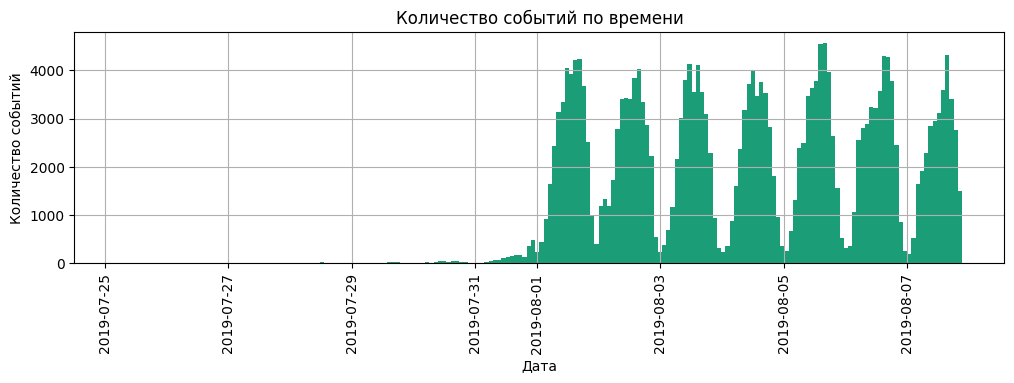

In [12]:
plt.figure(figsize=(12, 3))
data['event_time'].hist(bins=200)
plt.tick_params(axis='x', labelrotation = 90)
plt.title('Количество событий по времени')
plt.xlabel('Дата') 
plt.ylabel('Количество событий');

По гистограмме видно, что за первую неделю у пользователей не происходило практически никаких событий, тогда как во вторую неделю четко прослеживается активность пользователей в течении суток. Таким образом данные за первую неделю мусорные, скорее всего от них можно избавиться. Проверим, какой процент они составляют от всех событий:

In [13]:
first_week_event = data[data['event_time'] < '2019-08-01 00:00:00']['event_time'].count()
print('События за первую неделю от общего числа событий: ', '{:.2%}'.format(first_week_event / data.shape[0]))

События за первую неделю от общего числа событий:  1.16%


Посчитаем какой процент уникальных пользователей мы потеряем, если возьмем данные только за вторую неделю:

In [14]:
print('Процент уникальных пользователей, которые могут быть утеряны: ',
      '{:.2%}'.format(
          (data['id'].nunique() - data[data['event_time'] >= '2019-08-01 00:00:00']['id'].nunique())/data['id'].nunique()
      )
     )

Процент уникальных пользователей, которые могут быть утеряны:  0.23%


Так как потери незначительны, для дальнейшего анализа начальной датой проведения теста будем считать 2019-08-01 00:00:00, данные за ранний период удалим из выборки.

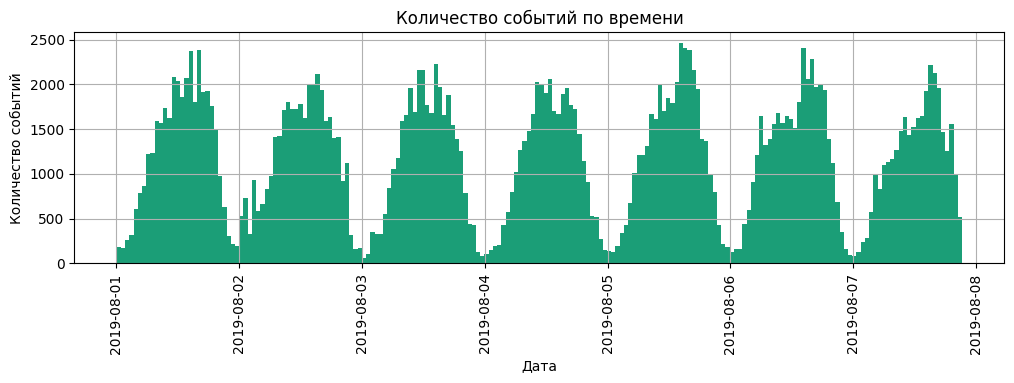

In [15]:
data = data[data['event_time'] >= '2019-08-01 00:00:00']
plt.figure(figsize=(12, 3))
data['event_time'].hist(bins=200)
plt.tick_params(axis='x', labelrotation = 90)
plt.title('Количество событий по времени')
plt.xlabel('Дата') 
plt.ylabel('Количество событий');

Теперь данные выглядят аккуратно. 
### Проверка количества пользователей
Изучим количество пользователей, использующих приложение в исследуемую неделю. 

In [16]:
print('Количество анализируемых событий: ', data['id'].count())
print('Количество пользователей: ', data['id'].nunique())
print('Среднее количество событий на пользователя: ', '{:.2f}'.format(data['id'].count() / data['id'].nunique()))

Количество анализируемых событий:  240887
Количество пользователей:  7534
Среднее количество событий на пользователя:  31.97


Проверим распределение пользователей по группам:

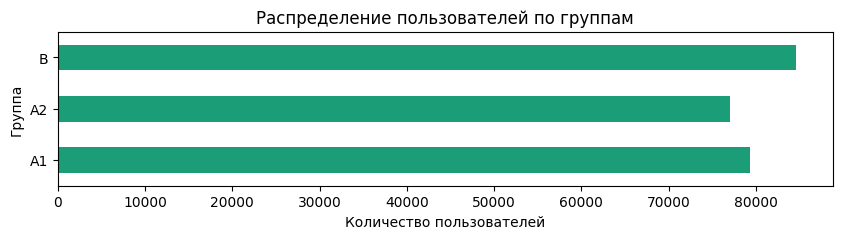

In [17]:
plt.figure(figsize=(10, 2))
data.groupby('group')['id'].count().plot(kind='barh')
plt.title('Распределение пользователей по группам')
plt.xlabel('Количество пользователей') 
plt.ylabel('Группа');

In [18]:
duplicate_users('A1', 'A2')
duplicate_users('A1', 'B')
duplicate_users('A2', 'B')

Количество уникальных пользователей, которые нахоятся в группе A1 и A2 одновременно 0
Количество уникальных пользователей, которые нахоятся в группе A1 и B одновременно 0
Количество уникальных пользователей, которые нахоятся в группе A2 и B одновременно 0


### Вывод

Мы располагаем данными за одну неделю: с 2019-08-01 по 2019-08-07 включительно. 

На 240887 событий приходится 7534 уникальных пользователей, в среднем на каждого пользователя приходится 32 события.

Пользователи для проведения A/A/B теста распределены на три группы. Визуально распределение по группам равномерно. Нет пользователей, которые одновременно присутствовали бы в двух или трех группах.

## Воронка событий


### Построение воронки событий
Изучим события, которые отслеживаются приложением:

In [19]:
print(f'Количество уникальных событий: ', (data['event_name_old'].nunique()), '\n')
print('События: \n', data['event_name_old'].unique(), '\n')

Количество уникальных событий:  5 

События: 
 ['Tutorial' 'MainScreenAppear' 'OffersScreenAppear' 'CartScreenAppear'
 'PaymentScreenSuccessful'] 



Переименуем события для своего удобства, создадим новый столбец:

In [20]:
data['event_name'] = data['event_name_old']
changing_values(data, 'event_name', [('MainScreenAppear', 'Главный экран'),
                                      ('OffersScreenAppear', 'Предложения'),
                                      ('CartScreenAppear', 'Корзина'),
                                      ('PaymentScreenSuccessful', 'Успешная оплата'),
                                      ('Tutorial', 'Обучение')])

In [21]:
print('Количество событий:')
(data.groupby('event_name')
     .agg({'id': 'count'})
     .sort_values(by='id', ascending=False)
     .rename(columns = {'id':'all_views'})
     .reset_index()
)

Количество событий:


,event_name,all_views
0,Главный экран,117328
1,Предложения,46333
2,Корзина,42303
3,Успешная оплата,33918
4,Обучение,1005


Очевидно, самое популярное событие - просмотр главного экрана. 

Подсчитаем сколько уникальных пользователей совершали каждое событие, а так же какую долю уникальные пользователи составляют от каждого события.

In [22]:
events = (data.groupby('event_name', as_index=False)
              .agg({'event_date': 'count', 'id' : 'nunique'})
              .rename(columns={'event_date':'all_views', 'id':'unic_user_views'})
              .sort_values(by='all_views', ascending=False)
              .reset_index(drop=True)
         )
events['part'] = events['unic_user_views'] / data['id'].nunique()
events

,event_name,all_views,unic_user_views,part
0,Главный экран,117328,7419,0.98
1,Предложения,46333,4593,0.61
2,Корзина,42303,3734,0.50
3,Успешная оплата,33918,3539,0.47
4,Обучение,1005,840,0.11


Около 2% пользователей миновали главный экран, возможно пользователи попадают на страницу предложений по прямой ссылке через уведомления, рекламу или поисковик. Так же возможно в эти 2% вошли пользователи, у которых первое событие пришлось на первую, отсеченную неделю.

Исходя из логики "пришел, увидел, купил" можем предположить что обязательный порядок страниц в приложении будет следующим:

- `Main Screen Appear` - Посещение главной страницы
- `Offers Screen Appear` - Просмотр предложений
- `Cart Screen Appear` - Посещение корзины
- `Payment Screen Successful` - Успешная оплата товаров

Событие `Tutorial` - просмотр обучения, возможно является необязательным и его можно пропустить, либо обучение открывается при первом открытии приложения после установки, т.е. за изучаемый 840 пользователей впервые воспользовались приложением.


Так как мы не может четко определить местоположение события `Tutorial` - 'Обучение' исключаем его из воронки.

Добавим данные для расчета воронки:
- `convABC` - часть пользователей, которые перешли с предыдущего события
- `loss` - "потеряная" часть пользователей с перыущего этапа
- `convA-C` - часть пользователей, дошедшая до этапа начиная с первого события.

,event_name,all_views,unic_user_views,part,convABC,loss,convA-C
0,Главный экран,117328,7419,0.98,1.00,0.00,1.00
1,Предложения,46333,4593,0.61,0.62,0.38,0.62
2,Корзина,42303,3734,0.50,0.81,0.19,0.50
3,Успешная оплата,33918,3539,0.47,0.95,0.05,0.48


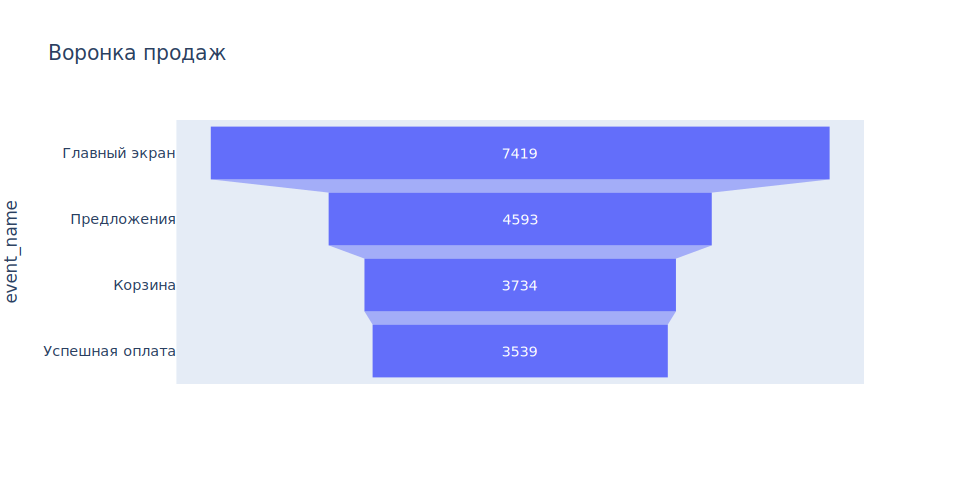

In [23]:
events = events.query('event_name != "Обучение"')

events['convABC'] = events['unic_user_views'] / (events['unic_user_views'].shift(1, fill_value=events.loc[0,'unic_user_views']))
events['loss'] = 1 - events['convABC']
events['convA-C'] = events['unic_user_views'] / events.loc[0,'unic_user_views']
display(events)
fig = px.funnel(events, x='unic_user_views', y='event_name',
                title='Воронка продаж',
                width=800, height=400         
               )
fig.show()

### Вывод

Всего приложение отслеживает 5 событий в следующем порядке:
- Посещение главной страницы
- Просмотр предложений
- Посещение корзины
- Успешная оплата товаров

И событие 'Обучение' которое не имеет четко определенного места в цепочке.

Самый большой процент клиентов теряется сразу после главной страницы, т.е. клиенты даже не заходят в раздел с товарами.
При этом 48% пользователей успешно доходят от первого события (просмотр главного экрана) до последнего (оплата заказа). 

## Результаты эксперимента

### Подготовка данных
Для оценки результатов эксперимента проведем вычисления:
- Подсчитаем количество пользователей в каждой группе
- Соберем таблицу, которая будет отображать события и количество пользователей в каждой группе, которые совершили это событие.
- Добавим суммарные значения для пользователей контрольных групп. 
- Добавим столбец с количеством уникальных пользователей в каждой группе.

In [24]:
grouped_count = data.groupby('group').agg({'id' : 'nunique'})
#Собираем таблицу, события и количество уникальных пользователей в каждой группе
grouped_data = (pd.pivot_table(data,
                               index='event_name',
                               columns='group',
                               values='id',
                               aggfunc={'id' : 'nunique'}).sort_values(by='A1', ascending=False)
                .reset_index()
                .query('event_name !="Обучение"') # Исключаем событие "обучение"
                .append(grouped_count.T, ignore_index=True) # добавляем число уникальных пользователей в каждой группе
               )
grouped_data.loc[grouped_data['event_name'].isnull(), 'event_name'] = 'Уникальные' # подписываем строчку
grouped_data['A1+A2']=grouped_data['A1'] + grouped_data['A2'] # Суммируем данные по контрольным группам
grouped_data

group,event_name,A1,A2,B,A1+A2
0,Главный экран,2450,2476,2493,4926
1,Предложения,1542,1520,1531,3062
2,Корзина,1266,1238,1230,2504
3,Успешная оплата,1200,1158,1181,2358
4,Уникальные,2484,2513,2537,4997


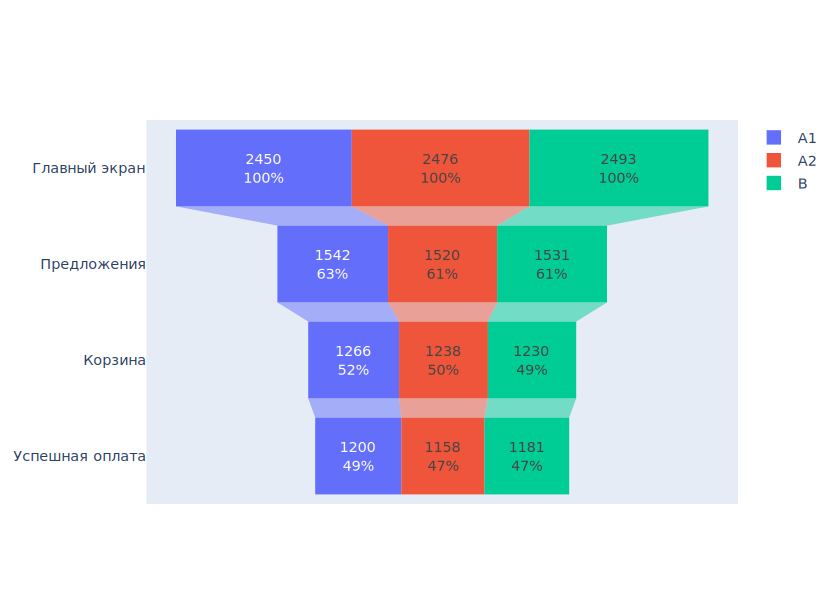

In [25]:
fig = go.Figure()

for i in ['A1', 'A2', 'B']:
    fig.add_trace(go.Funnel(
        name = i,
        y = grouped_data.query('event_name != "Уникальные"')['event_name'].unique(),
        x = grouped_data[i],
        textinfo = "value+percent initial"))

fig.show();

Даже визуально уже видно что группы имеют примерно одинаковыое распределение пользователей по событиям.

### A1/A2 эксперимент. Проверка расчетов

Так как у нас имеется 2 контрольные группы для эксперимента, мы можем провести А/А-тест и проверить корректность всех механизмов и расчётов. Проверим, находят ли статистические критерии разницу между выборками A1 и A2.

Так как мы хотим сравнить конверсию пользователей из посетивших первую страницу в успешно оформивших заказ воспользуемся двусторонним **z-test**'ом с показателем статистической значимости **alfa = 0.05**.

In [26]:
hypothesis_testing('A1', 'A2')

**Гипотезы:**

**Нулевая гипотеза**: Статистических различий в долях пользователей,     совершивших событие между группами **A1** и **A2** нет.

**Альтернативная**: Статистически значимые различия в долях пользователей,     совершивших событие между группами **A1** и **A2** есть.

Статистическая значимость **alfa = 0.05**

Для события **'Главный экран'**  значение p_value: **0.7570597232046099** результат теста:

**Не получилось отвергнуть нулевую гипотезу**,             нет оснований считать доли событий 'Главный экран' в группах A1 и A2 разными.

Для события **'Предложения'**  значение p_value: **0.2480954578522181** результат теста:

**Не получилось отвергнуть нулевую гипотезу**,             нет оснований считать доли событий 'Предложения' в группах A1 и A2 разными.

Для события **'Корзина'**  значение p_value: **0.22883372237997213** результат теста:

**Не получилось отвергнуть нулевую гипотезу**,             нет оснований считать доли событий 'Корзина' в группах A1 и A2 разными.

Для события **'Успешная оплата'**  значение p_value: **0.11456679313141849** результат теста:

**Не получилось отвергнуть нулевую гипотезу**,             нет оснований считать доли событий 'Успешная оплата' в группах A1 и A2 разными.

Так как тест не нашел статистически значимых различий между группами, у нас есть основания полагать что расчеты корректны.

### А1/В и А2/В эксперимент

In [27]:
hypothesis_testing('A1', 'B')

**Гипотезы:**

**Нулевая гипотеза**: Статистических различий в долях пользователей,     совершивших событие между группами **A1** и **B** нет.

**Альтернативная**: Статистически значимые различия в долях пользователей,     совершивших событие между группами **A1** и **B** есть.

Статистическая значимость **alfa = 0.05**

Для события **'Главный экран'**  значение p_value: **0.2949721933554552** результат теста:

**Не получилось отвергнуть нулевую гипотезу**,             нет оснований считать доли событий 'Главный экран' в группах A1 и B разными.

Для события **'Предложения'**  значение p_value: **0.20836205402738917** результат теста:

**Не получилось отвергнуть нулевую гипотезу**,             нет оснований считать доли событий 'Предложения' в группах A1 и B разными.

Для события **'Корзина'**  значение p_value: **0.07842923237520116** результат теста:

**Не получилось отвергнуть нулевую гипотезу**,             нет оснований считать доли событий 'Корзина' в группах A1 и B разными.

Для события **'Успешная оплата'**  значение p_value: **0.2122553275697796** результат теста:

**Не получилось отвергнуть нулевую гипотезу**,             нет оснований считать доли событий 'Успешная оплата' в группах A1 и B разными.

In [28]:
hypothesis_testing('A2', 'B')

**Гипотезы:**

**Нулевая гипотеза**: Статистических различий в долях пользователей,     совершивших событие между группами **A2** и **B** нет.

**Альтернативная**: Статистически значимые различия в долях пользователей,     совершивших событие между группами **A2** и **B** есть.

Статистическая значимость **alfa = 0.05**

Для события **'Главный экран'**  значение p_value: **0.4587053616621515** результат теста:

**Не получилось отвергнуть нулевую гипотезу**,             нет оснований считать доли событий 'Главный экран' в группах A2 и B разными.

Для события **'Предложения'**  значение p_value: **0.9197817830592261** результат теста:

**Не получилось отвергнуть нулевую гипотезу**,             нет оснований считать доли событий 'Предложения' в группах A2 и B разными.

Для события **'Корзина'**  значение p_value: **0.5786197879539783** результат теста:

**Не получилось отвергнуть нулевую гипотезу**,             нет оснований считать доли событий 'Корзина' в группах A2 и B разными.

Для события **'Успешная оплата'**  значение p_value: **0.7373415053803964** результат теста:

**Не получилось отвергнуть нулевую гипотезу**,             нет оснований считать доли событий 'Успешная оплата' в группах A2 и B разными.

При проведении тестов А1/В и А2/В ни по одному из событий статистических различий не обнаружено.
### А1+А2/В эксперимент

In [29]:
hypothesis_testing('A1+A2', 'B')

**Гипотезы:**

**Нулевая гипотеза**: Статистических различий в долях пользователей,     совершивших событие между группами **A1+A2** и **B** нет.

**Альтернативная**: Статистически значимые различия в долях пользователей,     совершивших событие между группами **A1+A2** и **B** есть.

Статистическая значимость **alfa = 0.05**

Для события **'Главный экран'**  значение p_value: **0.29424526837179577** результат теста:

**Не получилось отвергнуть нулевую гипотезу**,             нет оснований считать доли событий 'Главный экран' в группах A1+A2 и B разными.

Для события **'Предложения'**  значение p_value: **0.43425549655188256** результат теста:

**Не получилось отвергнуть нулевую гипотезу**,             нет оснований считать доли событий 'Предложения' в группах A1+A2 и B разными.

Для события **'Корзина'**  значение p_value: **0.18175875284404386** результат теста:

**Не получилось отвергнуть нулевую гипотезу**,             нет оснований считать доли событий 'Корзина' в группах A1+A2 и B разными.

Для события **'Успешная оплата'**  значение p_value: **0.6004294282308704** результат теста:

**Не получилось отвергнуть нулевую гипотезу**,             нет оснований считать доли событий 'Успешная оплата' в группах A1+A2 и B разными.

### Вывод

Тест показал, что отношение количества пользователей дошедших до оплаты ко всем пользователям в контрольных и эксперементальной группах практически совпадает.

Так как мы проводим множественное тестирование, а именно 16 тестов, чтобы снизить вероятность ложнопозитивного результата было бы необходимо применить поправки, например поправку Бонферрони.

In [30]:
bonferroni_alpha = 0.05 / 16
bonferroni_alpha

0.003125

В случае использования поправки критический уровень статистической значимости станет меньше, но так как мы не получили ни одного положительного результата теста, т.е. значение p_value ни разу не было выше значения alfa, то и применять поправку не имеет смысла.

## Общий вывод

В ходе исслеодвания мы изучили воронку событий:
- Самое частое событие - просмотр главного экрана, затем пользователи переходят на страницу с предложениями, в корзину и, наконец, успешно оплачивают свой заказ.
- Самая большая потеря клиентов происходит после посещения главной страницы - 38% пользователей не идут смотреть предложения.
- Тем не менее, дальнейшие потери не так значительны и 48% пользователей в итоге успешно оформляют заказ.
    
Возможно стоит обратить внимание разработчиков на такую большую потерю клиентов после первого же события. Возможно у пользователей возникают какие-то трудности при переходе с одной страницы на другую.
    
При изучении результатов проведения A/A/B эксперимента:

- По результатам A1/A2 эксперимента можно утверждать, что пльзователи корректно разделены на группы. По каждому из событий в группах А1 и А2 между долями пользователей совершивших покупки не наблюдается значительной статистической значимости. 
- Однако, и по результатам A1/В A2/И и A1+A2/В экспериментов значительных изменений не наблюдается, следовательно новый шрифт дизайнеров нельзя признать успешным. Тем не менее так же он и не отпугивает пользователей. 
- В связи с тем, что при проведении 16 тестов мы не получили ни одного положительного результата, поправки значения стат.значимости можно не применять.

Так как шрифт не повлиял на поведение пользователей, его введение можно оставить на усмотрение дизайнеров.